In [1]:
import pandas as pd
import numpy as np
#import operations as op
import cobra
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

import sys
import os

In [2]:
ecpy_path = '../../../ecpy/'
sys.path.append(os.path.abspath(ecpy_path))
import utils
import ecpy

In [3]:
import importlib
importlib.reload(utils)
importlib.reload(ecpy)

<module 'ecpy' from '/Users/gangl/Documents/GitHub/Halo-GEM/ecpy/ecpy.py'>

#### 1. Match kcat values
The input `max_KCAT.txt` file was downloaded from https://github.com/SysBioChalmers/GECKO/blob/master/databases/max_KCAT.txt.  
Only those kcat values from **Bacteria** will be used, since there is no kcat values available for this H. TD01. Following match criteria was used:  
(1) Try to match EC number and substrate  
(2) Try to match only EC number  
(3) If no match is found in above two steps, intoduce one wildcard to the last digit of the EC number. Then repeat step (1) and (2). If still no match is found, introduce two wildcards to the last two digits of the EC number. Then repeat again. Repeat until all digits of the EC number are replaced with wildcard.   
  
In the end, a list of kcat values is collected for each ec number. Use **the mean and standard deviation of log10-transformed values** as the estimated kcat and associated uncertainties.

Those kcat values have a unit of `1/s`

##### 1.1 Overview of the kcat database

In [4]:
kcat_file = '../../../ComplementaryData/max_KCAT.txt'
dfkcat = pd.read_csv(kcat_file,sep='\t',header=None)
dfkcat.columns = ['ec','substrate','species','kcat','comments']
print(dfkcat.shape)

(30162, 5)


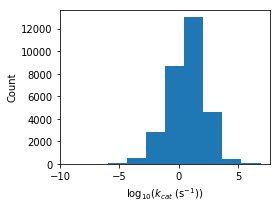

In [5]:
utils.plot_kcat_dist(dfkcat)

In [6]:
sel_ind = [ind for ind in dfkcat.index if 'bacteria' in dfkcat.loc[ind,'species']]
print(len(sel_ind))

10284


In [7]:
dfkcat = dfkcat.loc[sel_ind,:]

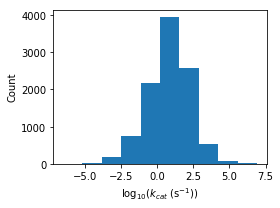

In [8]:
utils.plot_kcat_dist(dfkcat)

##### 1.2. Perform match
(1) Firstly load the GEM model  
(2) Convert it to an irreversible model  
(3) Do match

In [9]:
model_file = '../../../ModelFiles/json/Halo_GEM_v1.json'
model = cobra.io.load_json_model(model_file)

Using license file /Users/gangl/gurobi.lic
Academic license - for non-commercial use only


In [10]:
irrModel = ecpy.convertToIrrev(model)

In [11]:
rxn_kcats, case_count = ecpy.match_kcats(irrModel,dfkcat)

1850 / 2689 have been assigned with at least one ec number
Searching with 0 wildcard(s)


/Users/gangl/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472 PerformanceWarning: indexing past lexsort depth may impact performance.


1071 reactions are matched at this step. 1071/1850 are finished.

Searching with 1 wildcard(s)
731 reactions are matched at this step. 1802/1850 are finished.

Searching with 2 wildcard(s)
11 reactions are matched at this step. 1813/1850 are finished.

Searching with 3 wildcard(s)
4 reactions are matched at this step. 1817/1850 are finished.

Searching with 4 wildcard(s)
33 reactions are matched at this step. 1850/1850 are finished.



In [12]:
utils.report_match_kcats(case_count)

With 0 wildcards, kcats were found for 392 reactions by matching EC number and substrate
With 0 wildcards, kcats were found for 679 reactions by matching only EC number
With 1 wildcards, kcats were found for 144 reactions by matching EC number and substrate
With 1 wildcards, kcats were found for 587 reactions by matching only EC number
With 2 wildcards, kcats were found for 2 reactions by matching EC number and substrate
With 2 wildcards, kcats were found for 9 reactions by matching only EC number
With 3 wildcards, kcats were found for 4 reactions by matching only EC number
With 4 wildcards, kcats were found for 2 reactions by matching EC number and substrate
With 4 wildcards, kcats were found for 31 reactions by matching only EC number


##### 1.3 create an pd.DataFrame and visualize the resulting kcats  

In [25]:
def bootstrap_max(lst):
    max_vals = []
    for i in range(100): max_vals.append(np.max(np.random.choice(lst,len(lst))))
    return np.mean(max_vals),np.std(max_vals)

In [26]:
df_enz_ckat = pd.DataFrame()
for rxn_id,kcats in rxn_kcats.items():
    mean_log10_kcat = np.mean(np.log10(kcats))
    max_mean, max_std = bootstrap_max(np.log10(kcats))
    
    if len(kcats)>1: std_log10_kcat = np.std(np.log10(kcats))
    else: 
        std_log10_kcat = 1 #introduce a variance of 1 magnitude
        max_std = 1
    
    df_enz_ckat.loc[rxn_id,'log10_kcat_mean'] = mean_log10_kcat
    df_enz_ckat.loc[rxn_id,'log10_kcat_std'] = std_log10_kcat
    

    df_enz_ckat.loc[rxn_id,'log10_kcat_max'] = max_mean
    df_enz_ckat.loc[rxn_id,'log10_kcat_max_std'] = max_std
        
        
print(df_enz_ckat.shape)
df_enz_ckat.head(n=10)

(1850, 4)


,log10_kcat_mean,log10_kcat_std,log10_kcat_max,log10_kcat_max_std
RXN-6021,1.749244,0.915640,3.463043,0.285781
DEOXYRIBOSE-P-ALD-RXN,1.883541,0.734648,2.592954,0.319713
THREONINE-ALDOLASE-RXN,0.271842,1.000000,0.271842,1.000000
R02300_copy1,1.223489,0.118440,1.298665,0.052214
R02300_copy2,1.223489,0.118440,1.305291,0.034038
R00945,1.435783,0.816750,2.253935,0.773696
R00945_REV,0.698970,1.000000,0.698970,1.000000
RXN0-1461,-2.522879,1.000000,-2.522879,1.000000
GLUTATHIONE-REDUCT-NADPH-RXN,2.017161,0.526329,2.711642,0.271102
GLUTATHIONE-REDUCT-NADPH-RXN_REV,2.017161,0.526329,2.718093,0.279785


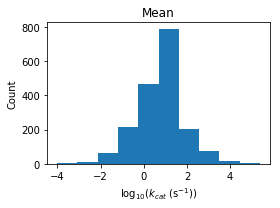

In [27]:
utils.plot_kcat_dist(df_enz_ckat,'log10_kcat_mean','Mean',True)

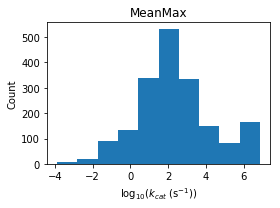

In [29]:
utils.plot_kcat_dist(df_enz_ckat,'log10_kcat_max','MeanMax',True)

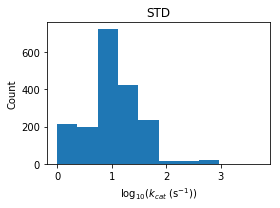

In [28]:
utils.plot_kcat_dist(df_enz_ckat,'log10_kcat_std','STD',True)

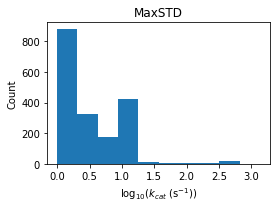

In [30]:
utils.plot_kcat_dist(df_enz_ckat,'log10_kcat_max_std','MaxSTD',True)

In [31]:
df_enz_ckat.to_csv('../Results/mapped_kcats.csv')

#### 2. Calculate molecular weighs for enzymes
In the enzyme constrained model, the unit for molecular weight is `g/mmol` which is corresponding to `kDa`

In [32]:
enzymes = []
for rxn_id in df_enz_ckat.index:
    rxn = irrModel.reactions.get_by_id(rxn_id)
    for gene in rxn.genes: enzymes.append(gene.id)
enzymes = list(set(enzymes))
print(len(enzymes))

1168


In [33]:
enz_seqs = SeqIO.to_dict(SeqIO.parse('../../../ComplementaryData/protein_sequences_v2.0.fasta','fasta'))

In [34]:
df_enz_mw = pd.DataFrame()
for enz in enzymes:
    seq = str(enz_seqs[enz].seq)
    seq = seq.replace('*','')
    pa = ProteinAnalysis(seq)
    mw = pa.molecular_weight()/1000 ## convert to kDa
    df_enz_mw.loc[enz,'mw'] = mw

In [35]:
df_enz_mw.head(n=5)

,mw
TD01GL003599,35.419836
TD01GL000170,67.223844
TD01GL002075,33.944536
TD01GL002983,81.953455
TD01GL000394,20.907750


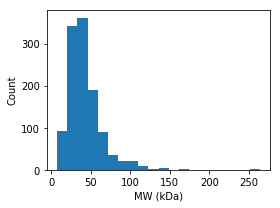

In [36]:
utils.plot_mw_dist(df_enz_mw)

In [37]:
df_enz_mw.to_csv('../Results/enzyme_MWs.csv')